In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Linear-nonlinear Poisson model

In the notebook on linear encoding models, we demonstrated how the operation of a neuron can be described as a linear filter acting on a stimulus. This filter can operate both in the time domain and the spatial domain, and the output could be considered a first approximation to the firing rate of a neuron. However, direct application of the filter can lead to the prediction of negative firing rates, which is obviously not what we want. To solve this issue, the output of the linear filtering stage can be passed through a nonlinearity so that the predicted firing rate is properly scaled. Finally, to go from a rate model to actual spikes, the rate produced by the nonlinear stage can be fed into a Poisson spike generator.

In this notebook we run a simulation of this model and show how the technique of white-noise analysis, or reverse correlation, can be used to recover both the components of such a model. 



## 1. The linear part
We will use a linear filter in the time domain. This filter was first described by Adelberg [REF] to describe ... . Mathematically it can be described by the following equation:

$$D(\tau) = \alpha \exp(-\alpha \tau) (\frac{(\alpha \tau)^5}{5!} - \frac{(\alpha \tau)^7}{7!})$$


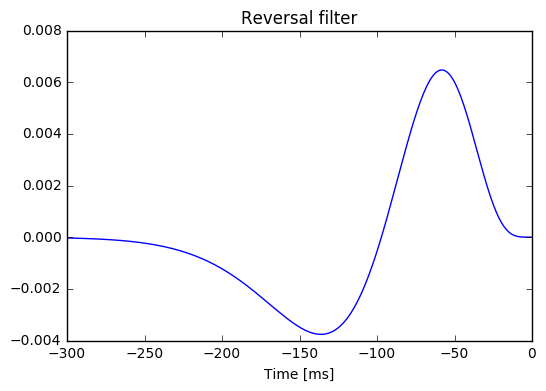

In [34]:
L = 300              # range [ms]
alpha = 1.0/15       # [ms]
t = np.arange(0,L,1) # range over which the filter acts

D = alpha*np.exp(-alpha*t)*( ((alpha*t)**5)/(np.math.factorial(5)) - ((alpha*t)**7)/np.math.factorial(7))

plt.plot(-t,D)
plt.title('Reversal filter')
plt.xlabel('Time [ms]')

## 2. A white noise stimulus
To generate a white noise stimulus we generate many different samples from a Gaussian distribution with mean 0 and variance 1. We can then calculate the linear response by convolving this stimulus with our filter. This produces an output that will also show variation, but now this variation is caused by how well the random noise stimulus resembles the linear filter. Note that this output also shows negative values, which we clearly do not want.

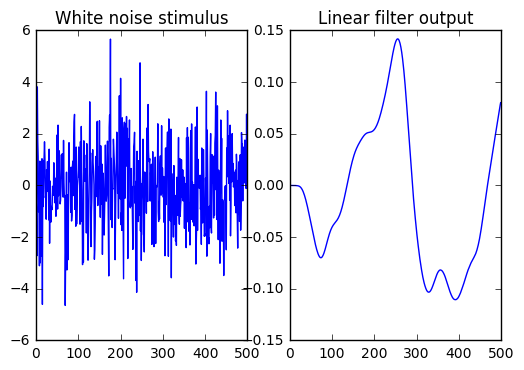

In [40]:
n_samples   = 500000
noise_stim  = np.random.normal(0.0,1.5,n_samples)
linear_resp = np.convolve(noise_stim,D)[:n_samples]
plt.subplot(1,2,1)
plt.plot(noise_stim[:500])
plt.title('White noise stimulus')
plt.subplot(1,2,2)
plt.plot(linear_resp[:500])
plt.title('Linear filter output')

## 3. A nonlinear stage
The nonlinear filter makes sure that the stimulus does not go below zero and also introduces a scaling factor. Here we have defined a filter that sets all negative values to zero. The linear response is then scaled and values larger than r_max are set equal to r_max.


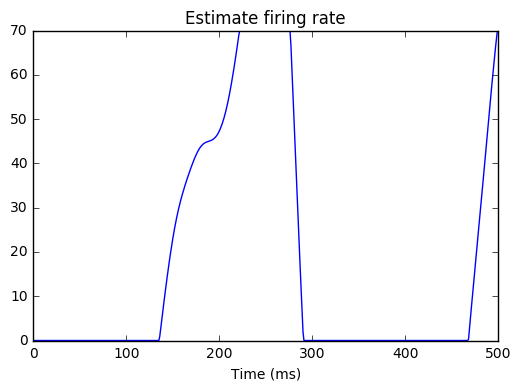

In [41]:
r_0 = 0    # Baseline firing rate [Hz]
r_max = 70 # maximam firing rate
scaling = 0.08
F_L = linear_resp.copy()
F_L[F_L < 0] = 0
F_L = r_max*(F_L/scaling)
F_L[F_L > r_max] = r_max
r_est = r_0 + F_L
plt.plot(r_est[:500])
plt.title('Estimate firing rate')
plt.xlabel('Time (ms)')

## 4. Poisson spike generator
Finally, we can use the estimated firing rate as input for a Poisson spike generator. Each timestep (here assumed to be equal to 1 ms), we generate a random value and if this value is smaller than the spiking probability we emit a spike at that point in time. Because the firing rate is no longer constant, spikes will start clustering where the predicted firing rate is high.

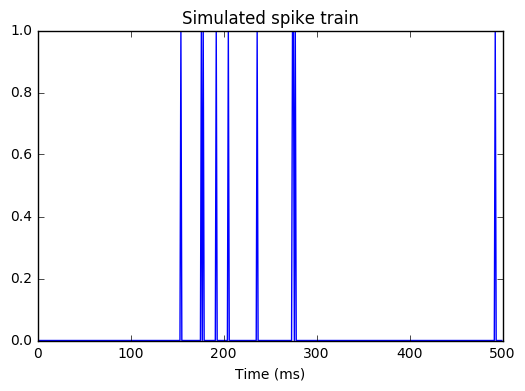

In [42]:
p = r_est*0.001
spikes = np.random.rand(n_samples)
spikes[spikes < p] = 1
spikes[spikes < 1] = 0

plt.plot(spikes[:500])
plt.xlabel('Time (ms)')
plt.title('Simulated spike train')

## 5. Spike triggered averaging
In this simulation, the linear and nonlinear stage are perfectly defined. But if we apply the same stimulation with white noise to a real neuron, we can recover the shape of the linear and nonlinear stage using the spike triggered average.

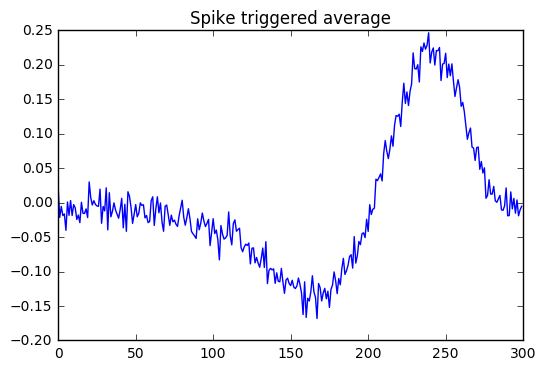

In [43]:
spike_times = np.where(spikes == 1)[0]
sta = np.zeros(L)
for i in spike_times:
    if i < L:
        continue
    
    sta += noise_stim[(i-L):i]

sta = sta/np.sum(spike_times > L)
plt.plot(sta)
plt.title('Spike triggered average')

The nonlinear part can also be recovered

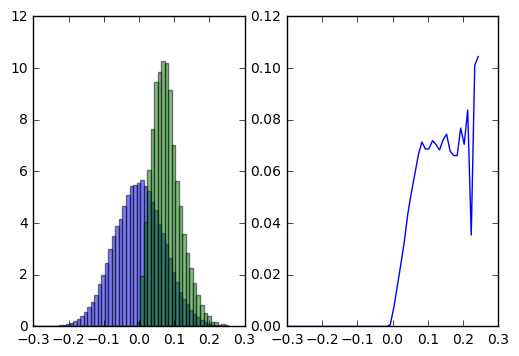

In [44]:
bins = np.arange(np.min(linear_resp),np.max(linear_resp),0.01)

raw_hist = np.histogram(linear_resp,bins)[0]
sta_hist = np.histogram(linear_resp[spikes == 1],bins)[0]

nl_estimate = np.true_divide(sta_hist,raw_hist)

plt.subplot(1,2,1)
plt.hist(linear_resp,bins, normed = True,alpha = 0.5)
plt.hist(linear_resp[spikes == 1],bins, normed = True,alpha = 0.5)
plt.subplot(1,2,2)
plt.plot(bins[:-1],nl_estimate)